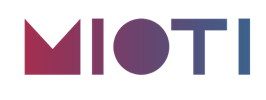
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>
<center style="color:#aaa; margin-top:10px;">Prof. Diego García Morate<br>diegogm@faculty.mioti.es</center>

# Worksheet S5: Clasificadores Lineales y NN

## Objetivos

El objetivo de este worksheet es que comprendas uno de los métodos de clasificación más usado las redes neuronales.

## Redes neuronales (NN)

Las redes neuronales (Neural networks) son uno de los clasificadores que han resurgido en los últimos años debido a los avances obtenidos mediante técnicas de deep learning. Este tipo de redes, aunque tienen una inspiración original basado en la biología del cerebro, se ha demostrado a lo largo de los años que su funcionamiento dista mucho de como funciona el cerebro humano.

<img src="brain_vs_nn.jpeg" width="80%">

Aprenderemos en este worksheet como funcionan las redes neuronales desde los clasificadores lineales:

## Configuración del entorno

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.set_printoptions(precision=3)
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import math

También vamos a cargar algunas funciones que nos resultarán interesantes.

In [2]:
def plot_2d_separator(classifier, X, y, fill=False, ax=None, eps=None):
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FFFF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    
    if eps is None:
        eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()

    ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels, colors="black")

In [3]:
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FFFF', '#FF00FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

In [4]:
from enum import Enum
class LogLevel(Enum):
    ALL = 0
    TRACE = 1
    DEBUG = 2
    INFO = 3
        
class Logger():
    def __init__(self, scope, level=LogLevel.INFO):
        self.scope = scope
        self.level = level
        
    def info(self, msg):
        if self.level.value > LogLevel.INFO.value:
            return
        
        print("INFO  [{}] {}".format(self.scope, msg))
        
    def debug(self, msg):
        if self.level.value > LogLevel.DEBUG.value:
            return
        
        print("DEBUG [{}] {}".format(self.scope, msg))
        
    def trace(self, msg):
        if self.level.value > LogLevel.TRACE.value:
            return
        
        print("TRACE [{}] {}".format(self.scope, msg))

## Dataset

Para ilustrar este ejemplo vamos a generar un dataset ficticio con la función `make_moons`:

In [5]:
from sklearn.datasets.samples_generator import make_blobs
dataset_X, dataset_y = make_blobs(cluster_std=2.75, n_samples=100, centers=3, n_features=2, random_state=42)

In [6]:
dataset_X[:,1] *= 100

In [7]:
dataset_X[:, 0] += 300

In [8]:
print(dataset_X[0])

[  290.792 -1104.594]


In [9]:
print(dataset_X[0])

[  290.792 -1104.594]


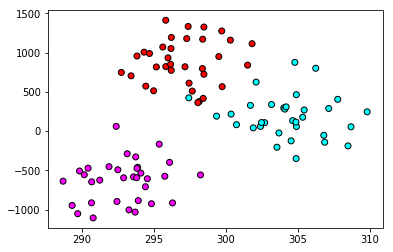

In [10]:
dibuja_dataset(dataset_X, dataset_y)

## Conjunto de entrenamiento y test

Como siempre, dividimos el dataset en conjunto de entrenamiento y test.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

## Clasificadores lineales

Imaginemos el siguiente problema: Tenemos dataset con 2 variables que queremos clasificar en 2 posibles categorias (clases): 0 y 1.

Este problema lo podemos reformular de la siguiente manera: Encontrar una función $f$ tal que aplicar la función sobre una instancia $x_i$ del dataset de entrada e incluyendo información previa $W$, $f(x_i; W)$ nos devuelva un número que indique la probabilidad de pertenencia de cada instancia $x_i$ a cada clase.

Un enfoque sencillo que podemos hacer es plantear un sistema de ecuaciones de la siguiente manera:

$$ x_i \times W = f(x_i; W) $$

Por ejemplo, si lo queremos aplicar sobre un elemento $x_i$ con valores $(0.1, 0.7)$ y matriz de pesos $W$ $((0.4, 0.8), (0.4, 0.1))$ podemos plantear un sistema de la siguiente manera:

$$
\left( \begin{array}{c}
0.1 & 0.7 
\end{array} \right)
\times
\left( \begin{array}{cc}
0.4 & 0.8 \\
0.3 & 0.1
\end{array} \right)
=
\left( \begin{array}{c}
0.25 & 0.15 
\end{array} \right)
$$

De esta manera, podemos tomar el vector resultado $(0.25, 0.15)$ e interpretarlo como la probabilidad de pertenencia a cada clase.

In [12]:
xi = np.array([0.1, 0.7])
W = np.array([[0.4, 0.8], [0.3, 0.1]])
print(xi.dot(W))

[0.25 0.15]


### Preguntas

* ¿Qué dimensiones tiene que tener la matrix W?

$$ (n_{instancias}, n_{atributos}) \times (n_{atributos}, n_{clases}) = (n_{instancias}, n_{clases})$$

* ¿Es realmente el vector resultante un vector de probabilidades?
* ¿Cómo podemos obtener esa matriz de pesos $W$?

## Fuerza bruta

Una primera aproximación que podrías plantear para encontrar una buena matriz $W$ es generar matrices $W$ aleatorias, probarlas con el conjunto de entrenamiento y quedarnos con la que mejor funcione.

Por ejemplo lo podemos hacer con el dataset que hemos cargado: 

In [13]:
def evalua_W(W, X, y, debug=False):
    aciertos = 0
    
    for i in range(len(X)): # Recorremos cada instancia
        # Proyectamos: W x x_i
        probs = np.dot(X[i], W)
                
        if probs[y[i]] == np.max(probs):
            aciertos += 1
            if debug:
                print("\tOK  y={} probs={} ".format(y[i], probs))
        else:
            if debug:
                print("\tBAD y={} probs={} ".format(y[i], probs))
    
    return aciertos / len(X)

Podemos probar la función con una matrix $W$ aleatoria:

In [14]:
num_features = dataset_X.shape[1]
num_classes = np.max(dataset_y) + 1

print("num_features: {}".format(num_features))
print("num_classes:  {}".format(num_classes))

# Generamos una matriz aleatoria
W = np.random.random((num_features, num_classes))
print("Creada matrix W aleatoria con dimensiones {}".format(W.shape))

# Evaluamos el porcentaje de acierto
acierto = evalua_W(W, X_train, y_train, debug=True)

print("Porcentaje de acierto: %.2f" % acierto)

num_features: 2
num_classes:  3
Creada matrix W aleatoria con dimensiones (2, 3)
	OK  y=2 probs=[  66.003 -202.064  242.783] 
	OK  y=2 probs=[ -39.174 -411.371  226.94 ] 
	BAD y=0 probs=[355.413 369.444 289.477] 
	OK  y=2 probs=[   4.449 -320.906  230.959] 
	OK  y=1 probs=[542.252 732.269 323.904] 
	BAD y=1 probs=[225.041 105.412 273.039] 
	OK  y=1 probs=[572.348 793.856 327.255] 
	OK  y=2 probs=[-225.01  -781.626  199.246] 
	BAD y=0 probs=[544.004 747.583 315.908] 
	OK  y=2 probs=[  11.388 -310.992  234.725] 
	BAD y=1 probs=[232.742 120.182 274.587] 
	BAD y=0 probs=[668.853 989.437 339.327] 
	BAD y=1 probs=[331.754 315.543 290.674] 
	BAD y=0 probs=[646.829 952.616 331.115] 
	OK  y=2 probs=[-179.939 -693.144  206.881] 
	OK  y=2 probs=[ -90.827 -515.185  219.872] 
	BAD y=1 probs=[253.272 160.993 277.712] 
	BAD y=0 probs=[ 698.012 1053.88   339.239] 
	OK  y=2 probs=[-169.8   -670.229  206.498] 
	BAD y=0 probs=[439.947 541.914 299.248] 
	BAD y=0 probs=[ 756.665 1169.372  348.934] 
	BAD y=

Y podemos expandir este enfoque a evaluar muchas matrices $W$ aleatorias para quedarnos con la mejor:

In [15]:
def entrena_clasificador_lineal_W(X, y):
    mejor_W = None
    mejor_acierto = 0
    
    num_features = X.shape[1]
    num_classes = np.max(y) + 1
    
    for i in range(5000):
        W = np.random.rand(num_features, num_classes)
        acierto = evalua_W(W, X, y)
            
        if acierto > mejor_acierto:
            mejor_acierto = acierto
            mejor_W = W
            print("[%05d] Porcentaje de acierto: %.3f" % (i, mejor_acierto))

    print("[  End] Porcentaje de acierto: %.3f" % (mejor_acierto))
    print("mejor_W:\n" + str(mejor_W))

In [16]:
entrena_clasificador_lineal_W(X_train, y_train)

[00000] Porcentaje de acierto: 0.343
[00001] Porcentaje de acierto: 0.586
[00003] Porcentaje de acierto: 0.600
[00006] Porcentaje de acierto: 0.629
[00012] Porcentaje de acierto: 0.743
[00117] Porcentaje de acierto: 0.814
[00374] Porcentaje de acierto: 0.843
[00552] Porcentaje de acierto: 0.886
[  End] Porcentaje de acierto: 0.886
mejor_W:
[[0.077 0.472 0.226]
 [0.752 0.416 0.053]]


## Mejorando la fuerza bruta

¿Cómo podríamos mejorar la fuerza bruta?

Unas de las principales debilidades es el espacio enorme que estamos evaluando, estamos generando matrices $W$ en un rango acotado [0, 1] y los datos no lo están. ¿Cómo podríamos mejorarlo?

In [17]:
np.random.rand(3,2)

array([[0.4  , 0.407],
       [0.748, 0.6  ],
       [0.369, 0.834]])

## Normalizando los datos

In [18]:
from scipy import stats
stats.describe(dataset_X)

DescribeResult(nobs=100, minmax=(array([  288.7  , -1104.594]), array([ 309.827, 1410.805])), mean=array([298.067, 152.61 ]), variance=array([2.764e+01, 4.615e+05]), skewness=array([ 0.323, -0.056]), kurtosis=array([-0.891, -1.068]))

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dataset_X)
dataset_X_norm = scaler.transform(dataset_X)

In [20]:
stats.describe(dataset_X_norm)

DescribeResult(nobs=100, minmax=(array([-1.791, -1.86 ]), array([2.248, 1.862])), mean=array([ 2.758e-14, -3.109e-17]), variance=array([1.01, 1.01]), skewness=array([ 0.323, -0.056]), kurtosis=array([-0.891, -1.068]))

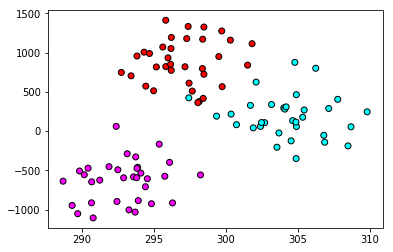

In [21]:
dibuja_dataset(dataset_X, dataset_y)

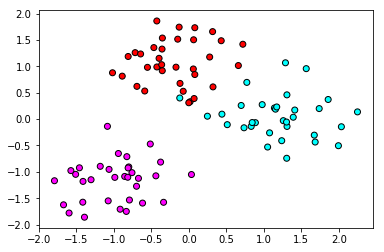

In [22]:
dibuja_dataset(dataset_X_norm, dataset_y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X_norm, dataset_y, test_size=.3, random_state=42)

In [24]:
def entrena_clasificador_lineal_W2(X, y):
    mejor_W = None
    mejor_acierto = 0
    
    num_features = X.shape[1]
    num_classes = np.max(y) + 1
    
    for i in range(5000):
        W = np.random.rand(num_features, num_classes) # Rango [0, 1]
        W *= 2 # Rango [0, 2]
        W -= 1 # Rango [-1, 1]
        acierto = evalua_W(W, X, y)
            
        if acierto > mejor_acierto:
            mejor_acierto = acierto
            mejor_W = W
            print("[%05d] Porcentaje de acierto: %.3f" % (i, mejor_acierto))

    print("[  End] Porcentaje de acierto: %.3f" % (mejor_acierto))
    print("mejor_W: " + str(mejor_W))

In [25]:
entrena_clasificador_lineal_W2(X_train, y_train)

[00000] Porcentaje de acierto: 0.457
[00004] Porcentaje de acierto: 0.543
[00005] Porcentaje de acierto: 0.571
[00011] Porcentaje de acierto: 0.714
[00021] Porcentaje de acierto: 0.943
[00118] Porcentaje de acierto: 0.957
[00125] Porcentaje de acierto: 0.986
[  End] Porcentaje de acierto: 0.986
mejor_W: [[-0.237  0.957 -0.966]
 [ 0.809 -0.013 -0.85 ]]


## Saliendo de la linearidad (función de activación)

Hemos visto hasta un clasificador lineal, que en un espacio 2D como el de los datos, es capaz de obtener un plano de separación entre los datos. Pero... no siempre los datos serán separables por planos lineales. ¿Es posible utilizar funciones algo más complicadas para generar planos de separación más complicadas?

La realidad es que si, e incorporando un poco de complejidad a nuestro clasificador podemos conseguir un clasificador no lineal. Estas funciones se denominan funciones de activación.

Una de las funciones de activación más utilizadas es la función sigmoide:

$$\frac{1}{1 + e^{-x}}$$

Que tiene la siguiente pinta:

<img src="sigmoide.png">

Podemos aplicarlo en nuestro ejemplo anterior de la siguiente manera:

In [26]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

def evalua_W_sigmoide(W, X, y):
    aciertos = 0
    for i in range(len(X)):
        probs = sigmoide(np.dot(X[i], W)) # W x x_i
        
        if probs[y[i]] == np.max(probs):
            aciertos += 1
    
    return aciertos / len(X)

def entrena_clasificador_lineal_W2_sigmoide(X, y, iteraciones):
    
    mejor_W = None
    mejor_acierto = 0
    
    num_features = X.shape[1]
    num_classes = np.max(y) + 1
    
    for i in range(iteraciones):
        W = np.random.rand(num_features, num_classes) # Rango [0, 1]
        W *= 2 # Rango [0, 2]
        W -= 1 # Rango [-1, 1]
        acierto = evalua_W_sigmoide(W, X, y)
            
        if acierto > mejor_acierto:
            mejor_acierto = acierto
            mejor_W = W
            print("[%05d] Porcentaje de acierto: %.3f" % (i, mejor_acierto))

    print("[  End] Porcentaje de acierto: %.3f" % (mejor_acierto))
    print("mejor_W: " + str(mejor_W))

In [27]:
entrena_clasificador_lineal_W2_sigmoide(X_train, y_train, 5000)

[00001] Porcentaje de acierto: 0.200
[00003] Porcentaje de acierto: 0.343
[00004] Porcentaje de acierto: 0.714
[00007] Porcentaje de acierto: 0.757
[00017] Porcentaje de acierto: 0.929
[00026] Porcentaje de acierto: 0.986
[  End] Porcentaje de acierto: 0.986
mejor_W: [[-0.481  0.772 -0.764]
 [ 0.862 -0.101 -0.111]]


## Función de pérdida


Esta bien utilizar el porcentaje de acierto como medida para guiar nuestro proceso de aprendizaje. No obstante el porcentaje de aciertos tiene el problema de que no es una función continua, ya que va por tramos en función de cuantas instancias tenemos.

* Si tenemos 1 instancias: los porcentajes de aciertos pueden ser: 0% o 100%
* Si tenemos 2 instancias: los porcentajes de aciertos pueden ser: 0%, 50% o 100%
* Si tenemos 3 instancias: 0%, 33%, 66%, 100%
* ...

Además nuestro objetivo no es sólo clasificar correctamente los distintos casos, sino que el clasificador, en este caso la red neuronal, discrimine al máximo unos casos y otros. Es decir, queremos que el vector resultado, si tenemos 2 clases (perros y gatos) no sea `[0.49, 0.51]` sino que, si relamente es un perro, sea ``[0.99, 0.001]``.

Para ello existen varias funciones de pérdida, la más habitual a día de hoy es `SoftMax` que se define de la siguiente manera:

$$ L_i = -log(\frac{e^{sy_i}}{\sum_j e^{S_j}}) $$

Parece muy complicada esta función, pero es fácil de entender con un ejemplo.

Supongamos que tenemos un clasificador que devuelve como resultado:

$$
\left( \begin{array}{cc}
Perro \\
Gato \\
Pájaro
\end{array} \right)
=
\left( \begin{array}{cc}
3.2 \\
5.1 \\
-1.7
\end{array} \right)
$$

Para poder calcular debemos calcular $e^x$ de los scores obtenidos:

$$
\left( \begin{array}{cc}
e^{3.2} \\
e^{5.1} \\
e^{-1.7}
\end{array} \right)
=
\left( \begin{array}{cc}
24.5 \\
164.0 \\
0.18
\end{array} \right)
$$

Esto nos devuelve las probabilidades no normalizadas. Ahora el siguiente paso es normalizarlas, que es tan fácil como dividir cada elemento entre la suma de todos:

$$ 24.5 + 164.0 + 0.18 = 188.68 $$

Y dividimos cada elemento entre el total:

$$
\frac{
\left( \begin{array}{cc}
24.5 \\
164.0 \\
0.18
\end{array} \right)
}{188.68}
=
\left( \begin{array}{cc}
0.13 \\
0.87 \\
0.00
\end{array} \right)
$$

De esta manera tenemos un vector de probabilidades por cada clase.

Para resumir en un número el valor de pérdida actual (diferencia respecto a la clase objetivo) nos quedamos con el $-log$ de la clase real. Es decir, si la clase real es Perro, la pérdida sería: $-log(0.13) = 0.89$.

Como podemos ver la pérdida en el caso óptimo (el vector de probabilidades nos devuelve un 1.0 en la clase real) es $-log(1) = 0$, y el peor caso (el vector de probabilidades nos devuelve un 0.0 en la clase real) es $-log(0)$ que es un valor no definido, pero tiende a $\infty$.

Como vemos nuestro objetivo es minimizar la función de pérdida. Es decir, llevarla a $0$ si es posible. ¿Cómo podríamos hacerlo?

In [28]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

def evalua_W_softmax(W, X, y):
    aciertos = 0
    loss = 0.0
    for i in range(len(X)):
        # W x x_i
        probs = sigmoide(np.dot(X[i], W))
        probs_exp = np.exp(probs)
        probs_exp /= probs_exp.sum()
        prob_real_class = probs_exp[y[i]]
                
        loss_i = 10.0
        if prob_real_class > 1e-6:
            loss_i = -1 * math.log(prob_real_class)
            
        loss += loss_i
    return loss / len(X)

def entrena_clasificador_lineal_W_softmax(X, y, iters):
    mejor_W = None
    mejor_loss = 999999.9
    
    num_features = X.shape[1]
    num_classes = np.max(y) + 1
    
    for i in range(iters):
        W = np.random.rand(num_features, num_classes) # Rango [0, 1]
        W *= 2 # Rango [0, 2]
        W -= 1 # Rango [-1, 1]
        W *= 0.01 # Rango [-0.01, 0.01]
        
        loss = evalua_W_softmax(W, X, y)        
        if loss < mejor_loss:
            mejor_loss = loss
            mejor_W = W
            print("[%05d] loss: %.4f" % (i, mejor_loss))

    print("[End] loss: %.4f" % (mejor_loss))
    print("mejor_W: " + str(mejor_W))

In [29]:
entrena_clasificador_lineal_W_softmax(X_train, y_train, 1000)

[00000] loss: 1.0997
[00001] loss: 1.0977
[00004] loss: 1.0975
[00012] loss: 1.0963
[00020] loss: 1.0958
[00356] loss: 1.0957
[End] loss: 1.0957
mejor_W: [[-0.007  0.008 -0.01 ]
 [ 0.006  0.006 -0.008]]


In [30]:
X_train.shape

(70, 2)

### Preguntas

* Si tiro una moneda al aire para clasificar en dos clases, ¿qué perdida debería tener?
* ¿Y si tiro un dado de 10 caras?
* ¿Qué relación hay entre la pérdida y el número de clases?

$$loss_{inicial} = -log(\frac{1}{n_{clases}})$$

In [31]:
-math.log(1/2)

0.6931471805599453

In [32]:
-math.log(1/3)

1.0986122886681098

In [33]:
-math.log(1/10)

2.3025850929940455

## Retropropagación

Hasta aquí hemos conseguido convertir nuestro resultado del clasificador lineal es una función de probabilidad continua. 

Pero tiene que haber una forma mejor de obtener la matrix $W$.  ¿Podríamos aprender de nuestros errores y a partir de ahí saber como podemos modificar la matriz W?

* Inicializar W con valores aleatorios
* Repetir:
  * Predecir el conjunto de entrenamiento
  * Calcular el error entre lo predicho y los valores esperados
  * Modificar la matriz W para reducir el error

### Descenso del gradiente

Imaginate que estás en un valle como este con los ojos cerrados:

<img src="valle.jpeg" width="60%">

#### ¿Qué harías para llegar a un valle?

La respuesta más simple sería caminar aleatoriamente. Esto es fácil de aplicar pero no nos garantiza llegar a un valle, y sólo si tenemos mucha suerte lo hagamos en un tiempo corto. 

Una opción mejor sería: cada vez que nos vamos a mover dar un pasito en varias direcciones y elegir la dirección en la que la pendiente que hemos bajado sea mayor. En el fondo es mirar a nuestro alrededor y seguir la mayor pendiente descendente. Esta técnica se denomina **descenso del gradiente** y es la base de las redes neuronales.

Vamos a pensar como aplicarlo a nuestro ejemplo del clasificador lineal.

La relación que existe entre la matriz $W$ y el valor del error obtenido $E$ tiene la siguiente pinta:

<img src="error_W.jpeg" width="30%">

Valores bajos de W tienen un error muy alto, y valores altos también. Existe un valle (o más de uno) en el que se minimiza el error. Nuestro objetivo es bajar ese valle y encontrar un mínimo local (que se parezca lo máximo posible a un mínimo global).

<img src="gradient_descent.png" width="50%">

Si pensamos en calcular pendientes, inmediatamente nos viene a la cabeza el concepto de derivada:

$$ \frac{df(x)}{dx} = lim_{h \implies 0} \frac{f(x + h) - f(x)}{h} $$

En realidad nuestro objetivo es, *en cada paso* calcular la derivada y dirigirnos hacia donde apunta.

Recordemos nuestra función sigmoide: 

$$\frac{1}{1 + e^{-x}}$$

Su derivada es:

$$x*(1-x)$$

Con estos conceptos ya podemos revisitar nuestro algoritmo de nuevo:

* (configure) Inicializar W con valores aleatorios
* (train) Repetir:
  * (forward) Predecir el conjunto de entrenamiento (sigmoide(Xi, W))
  * (loss) Calcular el error entre lo predicho y los valores esperados (softmax)
  * (backward + update_weights) Modificar la matriz W para reducir el error (derivada de forward)

## Uniendo todos los conceptos

In [34]:
class LinearLayer:
    """
    Implementación de un clasificador lineal.
    """
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        
        self.log = Logger("LinearLayer {}x{}".format(input_size, output_size))
            
        # Inicializamos la matriz W a valores aleatorios [-0.01, 0.01]
        self.W = np.random.uniform(size=(self.input_size, self.output_size), low=-0.0125, high=0.0125)
        self.log.info("Initialized W {}".format(self.W.shape))
        
    def sigmoide(self, x, is_backward = False):
        if is_backward == True:
            return x*(1-x)

        return 1 / (1 + np.exp(-x))
        
    def forward(self, input, is_last_layer=False):          
        self.cache_input = input
        
        if not is_last_layer:
            self.output = self.sigmoide(np.dot(input, self.W))
        else:
            self.output = np.dot(input, self.W)

        self.log.debug("[forward] output {}".format(self.output.shape))
        
    def backward(self, input_grad):
        self.output_grad = np.dot(self.sigmoide(input_grad, is_backward=True), self.W.T)
        self.dW = np.dot(self.cache_input.T, input_grad)
        
    def update_weights(self, learning_rate):
        self.log.debug("learning_rate: {}".format(learning_rate))
        self.log.debug("dW shape: {}".format(self.dW.shape))
        self.log.debug("W shape: {}".format(self.W.shape))
        self.W -= learning_rate * self.dW

        
class SoftMaxLoss:
    """
    Implementación de la función de pérdida softmax.
    """
    def __init__(self):
        self.log = Logger("SoftMaxLoss", level=LogLevel.INFO)
    
    def forward(self, input):
        self.log.debug("input: {}".format(input.shape))
        
        probs = np.exp(input) # Tenemos un vector con n-samples filas por sample y n-atributos columnas 
        self.log.trace("probs (exp): " + str(probs))
        
        sum_per_sample = probs.sum(axis=1)
        self.log.trace("total: " + str(sum_per_sample))
        
        probs = (probs.T / sum_per_sample).T 
        self.log.trace("probs norm: " + str(probs))
        
        self.output = probs
    
    def backward(self, y):
        probs_real_class = np.zeros((len(y)))
        self.output_grad = np.copy(self.output)
        
        for i in range(len(y)):
            p_real_class = self.output[i][y[i]]
            self.output_grad[i][y[i]] -= 1.0
            
            self.log.trace("p_real_class: " + str(p_real_class))
            if p_real_class < 1e-5:
                p_real_class = 9999999.0
            probs_real_class[i] = p_real_class
        self.log.trace("probs_real_class: %s" % str(probs_real_class))
        
        probs_real_class_log = -1 * np.log(probs_real_class)   
        self.log.trace("probs_real_class_log: %s" % str(probs_real_class_log))

        loss = probs_real_class_log.sum() / len(y)
        self.log.debug("loss: %.3f" % loss)
        
        return loss
    
class NeuralNetwork:
    """
    Implementación de la clase que gestiona toda la red neuronal.
    """
    def __init__(self, layers, loss_function=SoftMaxLoss(), learning_rate=5e-3):
        np.random.seed(1) # Fijamos la semilla de aleatorios en cada creación
        
        self.iterations_per_epoch = 25
        self.learning_rate = learning_rate
        self.learning_rate_decay = 0.95
        
        # Las capas son cada uno de los clasificadores lineales (LinearLayer) que ejecutaremos en serie
        self.layers = layers
        self.loss_function = loss_function
        
        self.log = Logger("NeuralNetwork")
        
    def forward(self, X):
        for i in range(len(self.layers)):
            is_last = (i == len(self.layers))
            
            if i == 0:
                self.layers[i].forward(X, is_last)
            else:
                self.layers[i].forward(self.layers[i - 1].output, is_last)
                
        self.loss_function.forward(self.layers[-1].output)
    
    def backward(self, y):
        loss = self.loss_function.backward(y)
        
        first = True
        for i in range(len(self.layers) - 1, -1, -1):
            self.log.debug("Backward layer {}".format(i))
            if i == len(self.layers) - 1:
                self.layers[i].backward(self.loss_function.output_grad)
            else:
                self.layers[i].backward(self.layers[i + 1].output_grad)
                
        return loss
    
    def update_weights(self):
        for layer in self.layers:
            layer.update_weights(self.learning_rate)
            
    def accuracy(self, y):
        aciertos = 0
        for i in range(len(self.loss_function.output)): # Recorremos cada instancia    
            probs = self.loss_function.output[i]            
            if probs[y[i]] == np.max(probs):
                aciertos += 1
        return aciertos / len(self.loss_function.output)
    
    def fit(self, X, y, iterations=100):
        self.log.info("Training nn...")
        
        for n in range(iterations):
            self.forward(X)      
            loss = self.backward(y) 
            self.update_weights()   
            
            if n % 10 == 0:
                self.log.info("[%05d] loss %f (lr=%f) (acc=%f)" % (n, loss, self.learning_rate, self.accuracy(y)))            

            if (n % self.iterations_per_epoch == 0) and n > 0:
                self.learning_rate *= self.learning_rate_decay                
                
        self.log.info("END ---------------")
        
    def predict(self, X):
        self.log.info("Predicting...")
        self.log.debug("X {}".format(X.shape))
        
        self.forward(X)
        return self.loss_function.output 

## 1 capa

In [35]:
num_features = dataset_X.shape[1]
num_classes = np.max(dataset_y) + 1

nn = NeuralNetwork(layers=[
    LinearLayer(num_features, num_classes), 
])

INFO  [LinearLayer 2x3] Initialized W (2, 3)


In [36]:
out = nn.predict(X_test)

INFO  [NeuralNetwork] Predicting...


In [37]:
out

array([[0.333, 0.334, 0.333],
       [0.334, 0.333, 0.333],
       [0.333, 0.334, 0.333],
       [0.333, 0.334, 0.333],
       [0.334, 0.333, 0.334],
       [0.332, 0.335, 0.333],
       [0.334, 0.332, 0.334],
       [0.333, 0.333, 0.333],
       [0.334, 0.333, 0.334],
       [0.334, 0.332, 0.334],
       [0.334, 0.332, 0.334],
       [0.334, 0.332, 0.334],
       [0.333, 0.333, 0.333],
       [0.333, 0.333, 0.333],
       [0.333, 0.335, 0.333],
       [0.334, 0.333, 0.333],
       [0.332, 0.335, 0.333],
       [0.334, 0.333, 0.333],
       [0.334, 0.333, 0.333],
       [0.332, 0.335, 0.333],
       [0.334, 0.333, 0.334],
       [0.334, 0.332, 0.334],
       [0.333, 0.334, 0.333],
       [0.333, 0.335, 0.333],
       [0.332, 0.335, 0.333],
       [0.334, 0.332, 0.334],
       [0.334, 0.332, 0.334],
       [0.333, 0.333, 0.333],
       [0.334, 0.332, 0.334],
       [0.334, 0.332, 0.334]])

In [38]:
nn.fit(X_train, y_train, iterations=1000)

INFO  [NeuralNetwork] Training nn...
INFO  [NeuralNetwork] [00000] loss 1.097058 (lr=0.005000) (acc=0.471429)
INFO  [NeuralNetwork] [00010] loss 0.815829 (lr=0.005000) (acc=0.985714)
INFO  [NeuralNetwork] [00020] loss 0.719827 (lr=0.005000) (acc=0.985714)
INFO  [NeuralNetwork] [00030] loss 0.679898 (lr=0.004750) (acc=0.985714)
INFO  [NeuralNetwork] [00040] loss 0.659932 (lr=0.004750) (acc=0.985714)
INFO  [NeuralNetwork] [00050] loss 0.648284 (lr=0.004750) (acc=0.985714)
INFO  [NeuralNetwork] [00060] loss 0.641206 (lr=0.004513) (acc=0.985714)
INFO  [NeuralNetwork] [00070] loss 0.636422 (lr=0.004513) (acc=0.985714)
INFO  [NeuralNetwork] [00080] loss 0.633095 (lr=0.004287) (acc=0.985714)
INFO  [NeuralNetwork] [00090] loss 0.630716 (lr=0.004287) (acc=0.985714)
INFO  [NeuralNetwork] [00100] loss 0.628912 (lr=0.004287) (acc=0.985714)
INFO  [NeuralNetwork] [00110] loss 0.627573 (lr=0.004073) (acc=0.985714)
INFO  [NeuralNetwork] [00120] loss 0.626513 (lr=0.004073) (acc=0.985714)
INFO  [NeuralN

Como vemos obtenemos buenos resultados sin embargo no llegamos al 100% de accuracy. ¿Cómo podríamos mejorar el ajuste del modelo?. 

### 2 capas

Una estrategia habitual para incrementar la complejidad del modelo es introducir más capas. Se denomina capa a cada clasificador que hemos introducido que ejecutaremos en cascada: es decir, el resultado de una capa es la entrada de la siguiente:

In [39]:
num_features = dataset_X.shape[1]
hidden_size = 15 # Tamaño de la capa oculta podemos poner el valor que queramos
num_classes = np.max(dataset_y) + 1

nn = NeuralNetwork(layers=[
    LinearLayer(num_features, hidden_size), 
    LinearLayer(hidden_size, num_classes)
])

INFO  [LinearLayer 2x15] Initialized W (2, 15)
INFO  [LinearLayer 15x3] Initialized W (15, 3)


Podemos evaluar la red que hemos implementado y ver como poco a poco la red disminuye su función de pérdida:

In [40]:
nn.fit(X_train, y_train, iterations=1000)

INFO  [NeuralNetwork] Training nn...
INFO  [NeuralNetwork] [00000] loss 1.098651 (lr=0.005000) (acc=0.342857)
INFO  [NeuralNetwork] [00010] loss 1.082541 (lr=0.005000) (acc=0.385714)
INFO  [NeuralNetwork] [00020] loss 1.050106 (lr=0.005000) (acc=0.385714)
INFO  [NeuralNetwork] [00030] loss 1.001427 (lr=0.004750) (acc=0.385714)
INFO  [NeuralNetwork] [00040] loss 0.959878 (lr=0.004750) (acc=0.385714)
INFO  [NeuralNetwork] [00050] loss 0.936468 (lr=0.004750) (acc=0.385714)
INFO  [NeuralNetwork] [00060] loss 0.928506 (lr=0.004513) (acc=0.385714)
INFO  [NeuralNetwork] [00070] loss 0.926602 (lr=0.004513) (acc=0.385714)
INFO  [NeuralNetwork] [00080] loss 0.926276 (lr=0.004287) (acc=0.385714)
INFO  [NeuralNetwork] [00090] loss 0.926230 (lr=0.004287) (acc=0.400000)
INFO  [NeuralNetwork] [00100] loss 0.926222 (lr=0.004287) (acc=0.485714)
INFO  [NeuralNetwork] [00110] loss 0.926220 (lr=0.004073) (acc=0.542857)
INFO  [NeuralNetwork] [00120] loss 0.926220 (lr=0.004073) (acc=0.585714)
INFO  [NeuralN

## 3 capas

In [41]:
num_features = dataset_X.shape[1]
hidden_size_1 = 15
hidden_size_2 = 5
num_classes = np.max(dataset_y) + 1

nn = NeuralNetwork(layers=[
    LinearLayer(num_features, hidden_size_1), 
    LinearLayer(hidden_size_1, hidden_size_2),     
    LinearLayer(hidden_size_2, num_classes)
], learning_rate=5e-4)

INFO  [LinearLayer 2x15] Initialized W (2, 15)
INFO  [LinearLayer 15x5] Initialized W (15, 5)
INFO  [LinearLayer 5x3] Initialized W (5, 3)


In [42]:
nn.fit(X_train, y_train, iterations=1000)

INFO  [NeuralNetwork] Training nn...
INFO  [NeuralNetwork] [00000] loss 1.098628 (lr=0.000500) (acc=0.342857)
INFO  [NeuralNetwork] [00010] loss 1.097919 (lr=0.000500) (acc=0.385714)
INFO  [NeuralNetwork] [00020] loss 1.097257 (lr=0.000500) (acc=0.385714)
INFO  [NeuralNetwork] [00030] loss 1.096648 (lr=0.000475) (acc=0.385714)
INFO  [NeuralNetwork] [00040] loss 1.096092 (lr=0.000475) (acc=0.385714)
INFO  [NeuralNetwork] [00050] loss 1.095568 (lr=0.000475) (acc=0.385714)
INFO  [NeuralNetwork] [00060] loss 1.095094 (lr=0.000451) (acc=0.385714)
INFO  [NeuralNetwork] [00070] loss 1.094648 (lr=0.000451) (acc=0.385714)
INFO  [NeuralNetwork] [00080] loss 1.094231 (lr=0.000429) (acc=0.385714)
INFO  [NeuralNetwork] [00090] loss 1.093848 (lr=0.000429) (acc=0.385714)
INFO  [NeuralNetwork] [00100] loss 1.093482 (lr=0.000429) (acc=0.385714)
INFO  [NeuralNetwork] [00110] loss 1.093148 (lr=0.000407) (acc=0.385714)
INFO  [NeuralNetwork] [00120] loss 1.092831 (lr=0.000407) (acc=0.385714)
INFO  [NeuralN

Podemos ver que a medida que se incrementan las capas crece la complejidad del modelo, aunque es más díficil entrenarlo.


## Perceptrón multicapa

Hasta aquí hemos visto como podemos evolucionar un clasificador lineal para:
* Llevarlo a un grado no lineal (sigmoide)
* Mejorar su función de error (softmax)
* Aprender de los errores (retropropagación)

Y ahora, la siguiente pregunta es... ¿podemos *componer distintos clasificadores lineales en cascada* y aplicar los conceptos vistos hasta ahora?. La respuesta es que si, y con la composición somos capaces de conseguir clasificadores más complejos. La composición de clasificadores lineales nos lleva a conseguir clasificadores no lineales.

Una arquitectura típica de composición es la denominada **perceptrón multicapa**:

<img src="neural_network.png" width="30%">

Consta de tres capas: una capa de entrada, una cada oculta y una de salida.

Podemos ver como cambiando la función de transformación cambia el hiperplano de separación:

http://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html

### Perceptrón multicapa en `sklearn`

Podemos utilizarlo en `sklearn` de la siguiente manera:

In [43]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

In [44]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [45]:
mlp.score(X_test, y_test)

1.0

Podemos consultar los parámetros que podemos modificar en:

http://devdocs.io/scikit_learn/modules/generated/sklearn.neural_network.mlpclassifier

Y jugar con ellos para ver los distintos resultados que se obtienen. Para ello puedes usar la siguiente función para ver como cambia el hiperplano de separación:

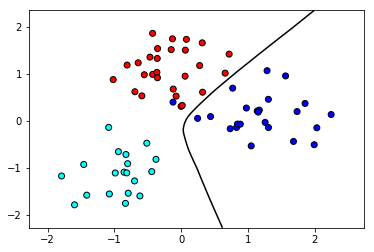

In [46]:
mlp = MLPClassifier(hidden_layer_sizes=(100, ))
mlp.fit(X_train, y_train)
plot_2d_separator(mlp, X_train, y_train)

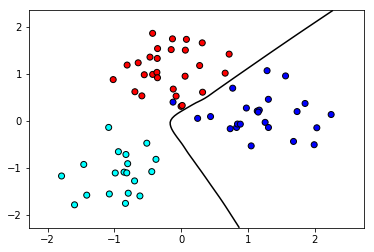

In [47]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100, ))
mlp.fit(X_train, y_train)
plot_2d_separator(mlp, X_train, y_train)

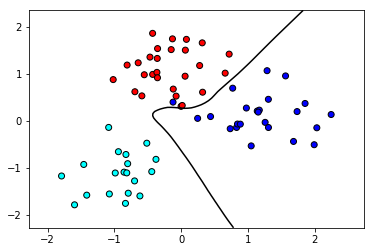

In [48]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100, 100,))
mlp.fit(X_train, y_train)
plot_2d_separator(mlp, X_train, y_train)

### (extra) Relación loss vs learning rate

<img src="loss_vs_lr.jpeg" width="60%">